In [6]:
!git clone https://github.com/tooclosetocall/23x-final-project.git data

Cloning into 'data'...
remote: Enumerating objects: 119081, done.
remote: Counting objects: 100% (30756/30756), done.
remote: Compressing objects: 100% (10001/10001), done.
remote: Total 119081 (delta 20349), reused 30756 (delta 20349), pack-reused 88325
Receiving objects: 100% (119081/119081), 3.26 GiB | 35.07 MiB/s, done.
Resolving deltas: 100% (81786/81786), done.
Checking out files: 100% (273856/273856), done.


Let's load the data into here and try to put up some basic models if we want
cuz its free

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models.
print_every = 100
print('Using device: ', device)

Using device:  /device:GPU:0


In [2]:
#Import labels into pandas dfs
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [4]:
train_df.head(5)

,label,merged_label,latitude,longitude,year,example_path
0,Timber plantation,Plantation,4.430849,96.101634,2014,examples/4.430849118860583_96.1016343478138
1,Other,Other,1.332341,109.374229,2012,examples/1.3323406178609702_109.37422873130464
2,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,examples/-1.7202663845775041_115.00699582064483
3,Small-scale agriculture,Smallholder agriculture,-2.248346,104.135786,2011,examples/-2.248346072674411_104.1357857482906
4,Other large-scale plantations,Plantation,-2.100800,113.022376,2008,examples/-2.100800102991412_113.02237632340159


In [4]:
#Turn training metadata into label vectors
y_train_u, y_train_ind = np.unique(train_df['label'], return_inverse=True)
y_train = np.zeros((y_train_ind.size, y_train_ind.max()+ 1))
y_train[np.arange(y_train_ind.size), y_train_ind] = 1

y_val_u, y_val_ind = np.unique(val_df['label'], return_inverse=True)
y_val = np.zeros((y_val_ind.size, y_val_ind.max()+ 1))
y_val[np.arange(y_val_ind.size), y_val_ind] = 1

y_test_u, y_test_ind = np.unique(test_df['label'], return_inverse=True)
y_test = np.zeros((y_test_ind.size, y_test_ind.max()+ 1))
y_test[np.arange(y_test_ind.size), y_test_ind] = 1

In [6]:
print("y_train: ", y_train_u)
print("y_val: ", y_val_u)
print("y_test: ", y_test_u)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

y_train:  ['Fish pond' 'Grassland shrubland' 'Logging' 'Mining'
 'Oil palm plantation' 'Other' 'Other large-scale plantations'
 'Secondary forest' 'Small-scale agriculture'
 'Small-scale mixed plantation' 'Small-scale oil palm plantation'
 'Timber plantation']
y_val:  ['Fish pond' 'Grassland shrubland' 'Logging' 'Mining'
 'Oil palm plantation' 'Other' 'Other large-scale plantations'
 'Secondary forest' 'Small-scale agriculture'
 'Small-scale mixed plantation' 'Small-scale oil palm plantation'
 'Timber plantation']
y_test:  ['Fish pond' 'Grassland shrubland' 'Logging' 'Mining'
 'Oil palm plantation' 'Other' 'Other large-scale plantations'
 'Secondary forest' 'Small-scale agriculture'
 'Small-scale mixed plantation' 'Small-scale oil palm plantation'
 'Timber plantation']
y_train:  (1616, 12)
y_val:  (473, 12)
y_test:  (668, 12)


In [5]:
#Turn images into 4d np array

#for infrared
X_train = []
for i,d in train_df.iterrows():
  example_path = d['example_path']
  image_path = os.path.join('data', os.path.join(example_path, 'images/visible/composite.png'))
  image = Image.open(image_path)
  image_arr = np.asarray(image)
  X_train.append(image_arr)
X_train = np.array(X_train)

X_val = []
for i,d in val_df.iterrows():
  example_path = d['example_path']
  image_path = os.path.join('data', os.path.join(example_path, 'images/visible/composite.png'))
  image = Image.open(image_path)
  image_arr = np.asarray(image)
  X_val.append(image_arr)
X_val = np.array(X_val)

X_test = []
for i,d in test_df.iterrows():
  example_path = d['example_path']
  image_path = os.path.join('data', os.path.join(example_path, 'images/visible/composite.png'))
  image = Image.open(image_path)
  image_arr = np.asarray(image)
  X_test.append(image_arr)
X_test = np.array(X_test)

In [8]:
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)

X_train:  (1616, 332, 332, 3)
X_val:  (473, 332, 332, 3)
X_test:  (668, 332, 332, 3)


In [ ]:
for i in range(668): #TODO: be 100% sure data is correctly labelled
  if(test_df['label'][i] == 'Fish pond'):
    print(test_df['label'][i])
    plt.imshow(X_test[i])
    plt.show()

In [6]:
#Save dimensions for later

#cutting them in two because my RAM is trash
N_train, H, W, C = X_train.shape
N_train, num_classes = int(y_train.shape[0]/), int(y_train.shape[1]/)
N_val, N_test = int(X_val.shape[0]/), int(y_test.shape[0]/)
input_shape = (H, W, C)

In [11]:
#Define simple model to make sure data works


hidden_layer_size = 400
initializer = tf.initializers.VarianceScaling(scale=2.0)
layersToby = [
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu',
                          kernel_initializer=initializer),
    tf.keras.layers.Dense(num_classes, activation='softmax', 
                          kernel_initializer=initializer),
]
poop_model = tf.keras.Sequential(layersToby)

In [12]:
#Set params for training
model = poop_model
learning_rate = 1e-5
optim = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [13]:
#Keras built-in train-eval loop
#REQUIRES:
#         model
#         optimizer
#         data
#         learning rate
model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train_ind, batch_size=64, epochs=3, validation_data=(X_val, y_val_ind))
model.evaluate(X_test, y_test_ind)

## TODO: Loss history
## TODO: list label names
## TODO: Build models
## TODO: Hyperparameter tuning

Epoch 1/3
26/26 [==============================] - 3s 25ms/step - loss: 158.7548 - sparse_categorical_accuracy: 0.1369 - val_loss: 2.8944 - val_sparse_categorical_accuracy: 0.1226
Epoch 2/3
26/26 [==============================] - 0s 18ms/step - loss: 2.6205 - sparse_categorical_accuracy: 0.1745 - val_loss: 2.6712 - val_sparse_categorical_accuracy: 0.1311
Epoch 3/3
21/21 [==============================] - 0s 6ms/step - loss: 2.7487 - sparse_categorical_accuracy: 0.1362


[2.7486631870269775, 0.136227548122406]

In [14]:
def trainCNN(lr,dropout):
  print("-----------------------------")
  print("lr: ",lr," dropout: ", dropout)
  optim = tf.keras.optimizers.Adam(learning_rate=lr)
  CN1 = models.Sequential()
  #ol' faithful conv and max X3
  CN1.add(layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal,input_shape = input_shape))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(64,(2,2),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  #then a conv with filter size one to decrease parameters
  CN1.add(layers.Conv2D(16,(1,1),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  #off to the first dimension
  CN1.add(layers.Flatten())
  CN1.add(layers.Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.Dense(num_classes,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal))

  CN1.compile(optimizer=optim,\
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),\
              metrics = [tf.keras.metrics.CategoricalAccuracy()])
  fitCN1 = CN1.fit(X_train, y_train, batch_size=64, epochs=120, validation_data=(X_val, y_val))
  print("eval:")
  CN1.evaluate(X_test, y_test)
  return (fitCN1, CN1)
  print("-----------------------------")

In [ ]:
for lr in [1e-4]:
  for drop in [.05]:
    fitCN1, CN1 = trainCNN(lr,drop)

In [ ]:
for (lr, drop), model in enumerate(CNNs)

In [ ]:
i =  58
print("y_val")
print(y_val[i])
print("x_val")
plt.imshow(X_val[i])
plt.show()
fourier = np.fft.fft2(X_val[i],axes=(0,1))/np.absolute(np.fft.fft2(X_val[i],axes=(0,1))).max()
plt.imshow(np.absolute(fourier))
plt.show()
print("prediction")
print(np.round(CN1.predict(X_val)[i],3))
print(y_val_u)


In [61]:
for i in range(10,20):
  testFFT = np.fft.fft2(X_train[i],axes=(0,1))
  testFFT *= 255/np.absolute(testFFT).max()
  print(testFFT.shape)
  #plt.imshow(X_train[i])
  #plt.show()
  #plt.imshow(np.absolute(testFFT))
  #plt.show()


(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)


In [11]:
#Create dataset for Fourier Transformed Data
N_FFT_train, N_FFT_val, N_FFT_test= N_train, N_val, N_test #TODO: normalize by the max value in the dataset

FFT_train = []
for i in range(N_FFT_train):
  FFT = np.fft.fft2(X_train[i],axes=(0,1))
  FFT *= 255/np.absolute(FFT).max()
  FFT_train.append(FFT)
FFT_train = np.asarray(FFT_train)

FFT_val = []
for i in range(N_FFT_val):
  FFT = np.fft.fft2(X_val[i],axes=(0,1))
  FFT *= 255/np.absolute(FFT).max()
  FFT_val.append(FFT)
FFT_val = np.asarray(FFT_val)

FFT_test = []
for i in range(N_FFT_test):
  FFT = np.fft.fft2(X_test[i],axes=(0,1))
  FFT *= 255/np.absolute(FFT).max()
  FFT_test.append(FFT)
FFT_test = np.asarray(FFT_test)

In [9]:
def trainFFT_CNN(lr,dropout):
  print("-----------------------------")
  print("lr: ",lr," dropout: ", dropout)
  optim = tf.keras.optimizers.Adam(learning_rate=lr)
  CN1 = models.Sequential()
  #ol' faithful conv and max X3
  CN1.add(layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal,input_shape = input_shape))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(64,(2,2),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  #then a conv with filter size one to decrease parameters
  CN1.add(layers.Conv2D(16,(1,1),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  #off to the first dimension
  CN1.add(layers.Flatten())
  CN1.add(layers.Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.Dense(num_classes,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal))

  CN1.compile(optimizer=optim,\
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),\
            metrics = [tf.keras.metrics.CategoricalAccuracy()])
  fitCN1 = CN1.fit(FFT_train, y_train[0:N_FFT_train], batch_size=64, epochs=50, validation_data=(FFT_val, y_val[0:N_FFT_val]))
  print("eval:")
  CN1.evaluate(FFT_test, y_test[0:N_FFT_test])
  return fitCN1
  print("-----------------------------")

In [ ]:
for lr in [1e-7, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]:
  for drop in [0, .05, 0.1, 0.15]:
    trainFFT_CNN(lr,drop)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

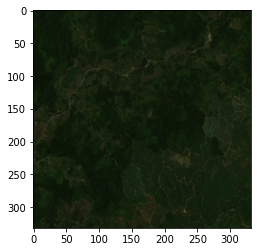

In [ ]:
#ya boy david in the house cuz no cap been doing a lot of the work
#so imma down three redbulls and a quesadilla and we gon make a homie
#prob not lez be honest
plt.imshow(X_train[0])
y_train[0]

In [29]:
X_train[0].shape

(332, 332, 3)

In [6]:
y_train_u
#we're gonna trust the pc cuz idk what shrubland means and these all sound
#the same to ya boy

array(['Fish pond', 'Grassland shrubland', 'Logging', 'Mining',
       'Oil palm plantation', 'Other', 'Other large-scale plantations',
       'Secondary forest', 'Small-scale agriculture',
       'Small-scale mixed plantation', 'Small-scale oil palm plantation',
       'Timber plantation'], dtype=object)

In [12]:
import pywt
coeffs = pywt.dwt2( X_train[0], axes=(0,1),wavelet='haar')
cA, (cH, cV, cD) = coeffs 
#the approximation from wavelets bases, horizontal,
#vertical and diagonal coefficients
'''cAMean = np.reshape(np.mean(cA,axis=2),(166,166,1))
cHMean = np.reshape(np.mean(cH,axis=2),(166,166,1))
cVMean = np.reshape(np.mean(cV,axis=2),(166,166,1))
cAHV = np.concatenate([cAMean,cHMean, cVMean],axis=2)
plt.imshow(cAHV)
cAHV.shape'''
cA.shape

def doubleSample(x):
  out = np.zeros((x.shape[0]*2,x.shape[0]*2))
  for i in range(x.shape[0]):
    for j in range(x.shape[0]):
      out[2*i,2*j] = x[i,j]
      out = np.reshape(out,(out.shape[0],out.shape[1],1))
  return out


In [36]:
maybe = doubleSample(np.mean(cA,axis=2))

In [39]:
FFT_train[0].shape

(332, 332, 3)

TypeError: ignored

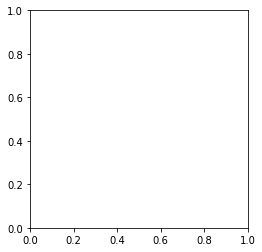

In [13]:
cA, (cH, cV, cD) = pywt.dwt2(X_train[0],'haar', axes=(0,1))
#Create dataset for Wavelet data
#copying Toby's code more or less
''' 
tried db6, haar, horizontal coeffs, horizontal+vert, all plus fft

if you want to do just WT w no FFT, just comment out all the cvmean2, chmean2 
and uncomment the versions without the 2s

TBH dont touch this. its broken
'''
N_WT_train, N_WT_val, N_WT_test= N_train, N_val, N_test #TODO: normalize by the max value in the dataset

#will work with horizontal coefficients for now

WT_train = []
for i in range(N_WT_train):
  cA, (cH, cV, cD) = pywt.dwt2(X_train[i],'haar', axes=(0,1))
  #WT *= 255/np.absolute(WT).max()
  #WT = np.concatenate([cH,cV],axis=2)
  #cAMean = np.reshape(np.mean(cA,axis=2),(cA.shape[0],cA.shape[0],1))
  #mean = np.reshape(np.mean(X_train[i],axis=2),(H,W,1))
  cHmean2 = doubleSample(np.mean(cH,axis=2))
  cVmean2 = doubleSample(np.mean(cV,axis=2))
  #cHMean = np.reshape(np.mean(cH,axis=2),(cH.shape[0],cH.shape[0],1))
  #cVMean = np.reshape(np.mean(cV,axis=2),(cV.shape[0],cV.shape[0],1))

  cAHV = np.concatenate([FFT_train[i],cHmean2, cVmean2],axis=2)
  WT_train.append(cAHV)
FFT_train = np.asarray(WT_train)
del(X_train)

WT_val = []
for i in range(N_WT_val):
  cA, (cH, cV, cD) = pywt.dwt2(X_val[i],'haar', axes=(0,1))
  #WT *= 255/np.absolute(WT).max()
  #WT = np.concatenate([cH,cV],axis=2)
  #cAMean = np.reshape(np.mean(cA,axis=2),(cA.shape[0],cA.shape[0],1))
  #mean = np.reshape(np.mean(X_val[i],axis=2),(H,W,1))
  cHmean2 = doubleSample(np.mean(cH,axis=2))
  cVmean2 = doubleSample(np.mean(cV,axis=2))
  #cHMean = np.reshape(np.mean(cH,axis=2),(cH.shape[0],cH.shape[0],1))
  #cVMean = np.reshape(np.mean(cV,axis=2),(cV.shape[0],cV.shape[0],1))
  cAHV = np.concatenate([FFT_val[i],cHmean2, cVmean2],axis=2)
  WT_val.append(cAHV)
FFT_val = np.asarray(WT_val)
del(X_val)

WT_test = []
for i in range(N_WT_test):
  cA, (cH, cV, cD) = pywt.dwt2(X_test[i],'haar', axes=(0,1))
  #WT *= 255/np.absolute(WT).max()
  #WT = np.concatenate([cH,cV],axis=2)
  #cAMean = np.reshape(np.mean(cA,axis=2),(cA.shape[0],cA.shape[0],1))
  #mean = np.reshape(np.mean(X_test[i],axis=2),(H,W,1))
  cHmean2 = doubleSample(np.mean(cH,axis=2))
  cVmean2 = doubleSample(np.mean(cV,axis=2))
  #cHMean = np.reshape(np.mean(cH,axis=2),(cH.shape[0],cH.shape[0],1))
  #cVMean = np.reshape(np.mean(cV,axis=2),(cV.shape[0],cV.shape[0],1))
  cAHV = np.concatenate([FFT_test[i],cHmean2, cVmean2],axis=2)
  WT_test.append(cAHV)
FFT_test = np.asarray(WT_test)
del(X_test)
WT_input_shape = FFT_train[0].shape
plt.imshow(FFT_train[0])


In [18]:
WT_input_shape = FFT_train[0].shape

In [16]:
def trainWT_CNN(lr,dropout): #looks familiar
  lol = ['you got this', 'keep at it', "show that Fourier Transforms who's boss", 'who even is error?']
  daLine = "-----------------------------"
  print(daLine)
  print("lr: ",lr," dropout: ", dropout)
  optim = tf.keras.optimizers.Adam(learning_rate=lr)
  CN1 = models.Sequential()
  #ol' faithful conv and max X3
  CN1.add(layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal,input_shape = WT_input_shape))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal,input_shape = WT_input_shape))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(32,(2,2),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  CN1.add(layers.Conv2D(64,(2,2),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  CN1.add(layers.MaxPooling2D((2,2)))
  #then a conv with filter size one to decrease parameters
  CN1.add(layers.Conv2D(16,(1,1),activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal))
  CN1.add(layers.Dropout(dropout))
  #off to the first dimension
  CN1.add(layers.Flatten())
  CN1.add(layers.Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.he_normal))
  #CN1.add(layers.Dropout(dropout))
  CN1.add(layers.Dense(num_classes,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal))

  CN1.compile(optimizer=optim,\
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),\
            metrics = [tf.keras.metrics.CategoricalAccuracy()])
  fitCN1 = CN1.fit(FFT_train, y_train[0:N_WT_train], batch_size=64, epochs=120, validation_data=(FFT_val, y_val[0:N_WT_val]))
  print("eval:")
  CN1.evaluate(FFT_test, y_test[0:N_WT_test])
  return fitCN1
  print(daLine)
  if np.random.rand()>.75:
    k = np.random.randint(4)
    print(lol[k])
    print(daLine)


In [15]:
for _ in range(20):
  print(np.random.rand())

0.17310391404868797
0.7973408984049883
0.37501173176540736
0.9392390014831201
0.17872102791353772
0.3419089826237264
0.4479195473304445
0.08786922113262408
0.5596377529807283
0.9734329400338423
0.19460925248500494
0.5690337186056345
0.387769570261004
0.8449059965689784
0.30292761225883247
0.48687238092867513
0.39592049548002994
0.7130975546865639
0.08732009468738866
0.4040410985437226


In [19]:
for lr in [1e-6,1e-5,1e-4,1e-3]:
  for drop in [.05,.125, .175, .2]:
    trainWT_CNN(lr,drop)


-----------------------------
lr:  1e-06  dropout:  0.05
Epoch 1/120


ValueError: ignored

In [57]:
print(fitCN1.history.keys)

NameError: ignored

In [ ]:
  testFFT = np.fft.fft2(X_train[i],axes=(0,1))
  testFFT *= 255/np.absolute(testFFT).max()

  